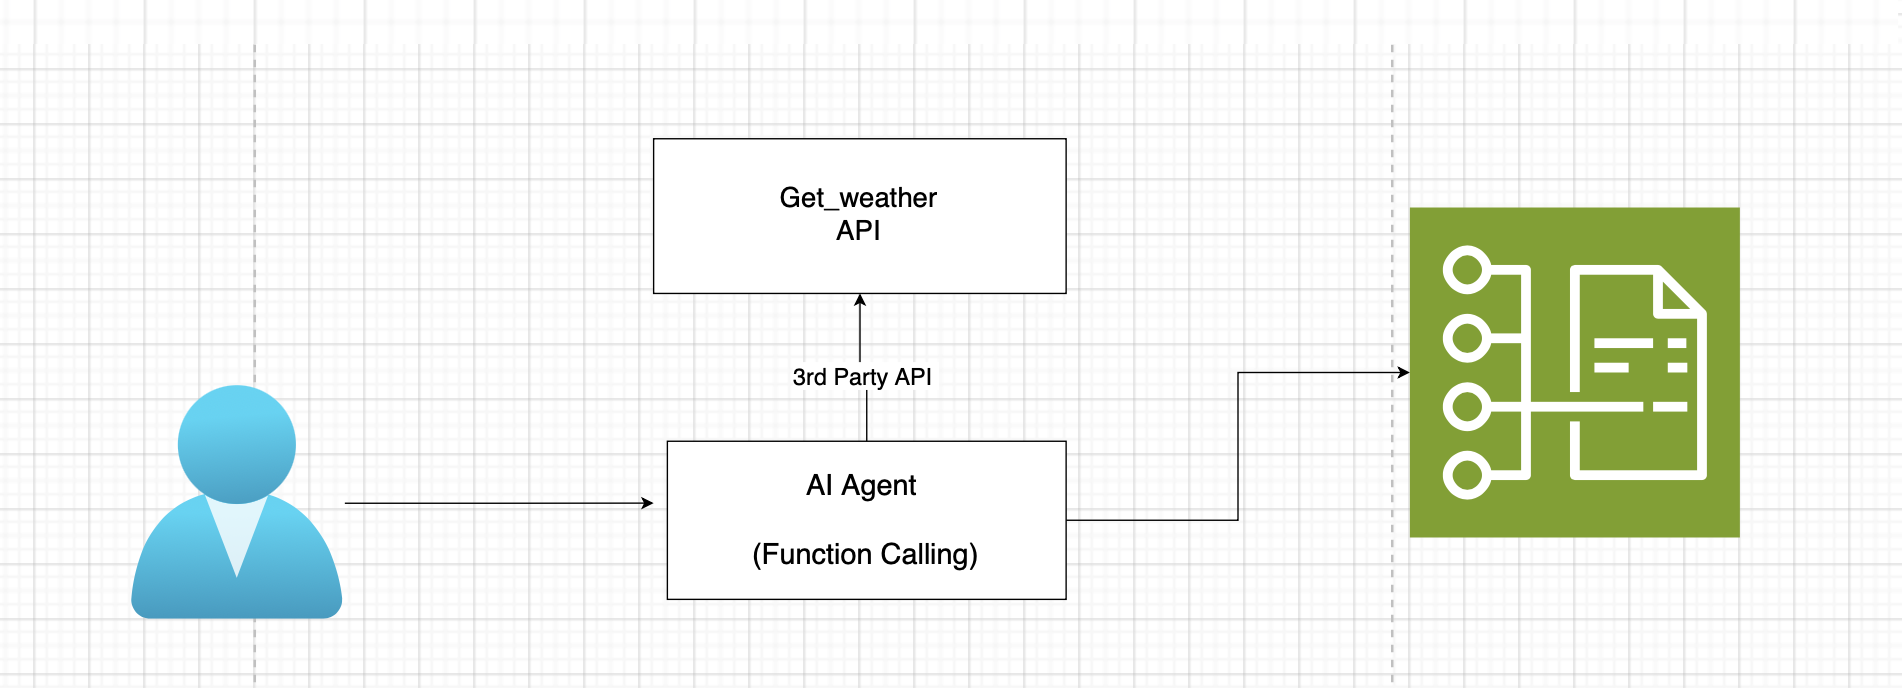

In [ ]:
# Installs the Azure AI Projects SDK and Azure Identity library for authentication
#!pip install azure-ai-projects==1.0.0b6 azure-identity==1.21.0 load_dotenv


In [1]:
# Set up your environment variables for the Azure OpenAI endpoint and API key.

import os
from dotenv import load_dotenv
load_dotenv('agents.env')
CLIENT_ID = os.getenv("CLIENT_ID")
CLIENT_SECRET = os.getenv("CLIENT_SECRET")
TENANT_ID = os.getenv("TENANT_ID")
PROJECT_ENDPOINT = os.getenv("PROJECT_ENDPOINT")
OPENWEATHER_MAP_API_KEY = os.getenv("OPENWEATHER_MAP_API_KEY")


In [ ]:
# Setup the Function Definition fo get_weather

import os
import json
import requests

# Function to Get Weather Information
def get_weather(latitude: float, longitude: float) -> str:
    """
    Retrieves the weather condition for a given location using latitude and longitude.

    :param latitude (float): Latitude of the location.
    :param longitude (float): Longitude of the location.
    :return: Weather details as a JSON string.

    """

    # Validate latitude and longitude
    if latitude is None or longitude is None:
        return json.dumps({"error": "Latitude and longitude are required."})
    if latitude > 90 or latitude < -90:
        return json.dumps({"error": "Invalid latitude value. It must be between -90 and 90."})
    if longitude > 180 or longitude < -180:
        return json.dumps({"error": "Invalid longitude value. It must be between -180 and 180."})

    # Weather API Endpoint
    complete_url = f"https://api.open-meteo.com/v1/forecast?latitude={latitude}&longitude={longitude}&current_weather=true"

    try:
        # Make the API request
        response = requests.get(complete_url)
        weather_data = response.json()  # Parse JSON response

        # Check for API errors
        if response.status_code != 200:
            return json.dumps({"error": weather_data.get("message", "Failed to fetch weather data.")})

        # Extract weather details
        wind_speed = weather_data["current_weather"]["windspeed"]
        temperature =weather_data["current_weather"]["temperature"]
        is_day = weather_data["current_weather"]["is_day"]

        return json.dumps({
            "latitude": latitude,
            "longitude": longitude,
            "wind_speed": wind_speed,
            "temperature": temperature,
            "is_day": is_day
        })
    except Exception as e:
        return json.dumps({"error": str(e)})


In [ ]:
# Creating & Calling the Azure AI Agent

import os  # Provides a way to interact with the operating system, such as accessing environment variables.
import json  # Used for working with JSON data (e.g., parsing and serializing JSON).
import requests  # A library for making HTTP requests to interact with web APIs.
from azure.ai.projects import AIProjectClient  # Provides the main client to interact with Azure AI Project services.
from azure.identity import ClientSecretCredential  # Used for authenticating with Azure using credentials.
from azure.ai.agents.models import FunctionTool, ToolSet # Correct import for FunctionTool and ToolSet
from typing import Any, Callable, Set

# Collect user functions to be used as tools
user_functions: Set[Callable[..., Any]] = {get_weather}

# Main execution block
if __name__ == "__main__":
    # Configure Azure credentials using environment variables
    credential = ClientSecretCredential(
        tenant_id=os.getenv("TENANT_ID"),
        client_id=os.getenv("CLIENT_ID"),
        client_secret=os.getenv("CLIENT_SECRET")
    )

    # Initialize Azure AI Project Client
    project_client = AIProjectClient(
        endpoint=os.environ["PROJECT_ENDPOINT"] ,
        credential=credential,  # Use Azure Default Credential for authentication
    )

    # Create toolset with custom functions
    functions = FunctionTool(functions=user_functions)
    toolset = ToolSet()
    toolset.add(functions)

    # Create the Azure AI Agent with specified configuration
    agent = project_client.agents.create_agent(
        model=os.environ["MODEL_DEPLOYMENT_NAME"],  # Model deployment name
        name="weather-agent",  # Name of the agent
        instructions="You are a helpful agent that provides weather information using real-time data",  # Instructions for the agent
        tools=toolset.definitions,
    )
    
    # Enable automatic function calls
    project_client.agents.enable_auto_function_calls(
        tools=toolset,
        max_retry=5  # optional
    )


    # Create a conversation thread
    thread = project_client.agents.threads.create()


    # Interactive conversation loop
    while True:
        # Prompt for user input
        user_input = input("User: ")

        # Exit condition
        if user_input.lower() == "end":
            print("Ending the conversation.")
            break

        # Send user message to the agent
        message = project_client.agents.messages.create(
            thread_id=thread.id,
            role="user",  # Role of the message sender
            content=user_input,  # Message content
        )

        # Process the agent's run
        run = project_client.agents.runs.create_and_process(
            thread_id=thread.id,
            agent_id=agent.id,
        )

        # Check for run failures
        if run.status == "failed":
            print(f"Run failed: {run.last_error}")
            break

        # Retrieve and display only the latest assistant response
        messages = project_client.agents.messages.list(thread_id=thread.id)
        assistant_messages = [m for m in messages if m.role == "assistant"]
        if assistant_messages:
            latest = assistant_messages[0]
            for part in latest.content:
                if hasattr(part, "text"):
                    print(f"Agent response: {part.text.value}")
                else:
                    print(f"Agent response: {part}")

    # Optional: Delete the agent (currently commented out)
    # project_client.agents.delete_agent(agent.id)
    print("Conversation ended")

Agent response: The weather in Copenhagen is currently 14.6°C with a wind speed of 25.9 km/h. It is daytime in Copenhagen.
Agent response: The weather in London is currently 16.2°C with a wind speed of 4.0 km/h. It is daytime in London.
Ending the conversation.
Conversation ended
